In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install -q kaggle


In [ ]:
!kaggle datasets download -d emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 99% 651M/658M [00:01<00:00, 244MB/s]
100% 658M/658M [00:01<00:00, 362MB/s]


In [ ]:
!unzip -q plantdisease.zip -d plant_disease_data

In [ ]:
import os
from PIL import Image

In [ ]:
print(os.listdir('plant_disease_data'))

['PlantVillage', 'plantvillage']


In [7]:
from pathlib import Path
root = Path('/content')
for item in root.iterdir():
    print(item)


/content/.config
/content/kaggle.json
/content/plantdisease.zip
/content/plant_disease_data
/content/sample_data


In [8]:
data_dir = Path('/content/plant_disease_data')

In [9]:
for item in (data_dir / "PlantVillage").iterdir():
    print(item)

/content/plant_disease_data/PlantVillage/Tomato_Septoria_leaf_spot
/content/plant_disease_data/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus
/content/plant_disease_data/PlantVillage/Potato___Late_blight
/content/plant_disease_data/PlantVillage/Tomato__Tomato_mosaic_virus
/content/plant_disease_data/PlantVillage/Tomato_Bacterial_spot
/content/plant_disease_data/PlantVillage/Tomato_Leaf_Mold
/content/plant_disease_data/PlantVillage/Tomato__Target_Spot
/content/plant_disease_data/PlantVillage/Potato___Early_blight
/content/plant_disease_data/PlantVillage/Potato___healthy
/content/plant_disease_data/PlantVillage/Pepper__bell___healthy
/content/plant_disease_data/PlantVillage/Pepper__bell___Bacterial_spot
/content/plant_disease_data/PlantVillage/Tomato_Early_blight
/content/plant_disease_data/PlantVillage/Tomato_healthy
/content/plant_disease_data/PlantVillage/Tomato_Late_blight
/content/plant_disease_data/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite


Data Loading and Preprocessing

We use Keras’s ImageDataGenerator for loading images and on-the-fly data augmentation
blog.keras.io
. This lets us rescale pixel values and apply random transformations (rotations, shifts, flips, etc.) to improve generalization. A validation split (e.g. 20%) is used to hold out data for evaluation. In code, we set up one generator for training (with augmentations) and one for validation (only rescaling):

In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator



data_dir = Path('/content/plant_disease_data/PlantVillage')
assert data_dir.exists(), f"Dataset directory {data_dir} not found."


IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    directory=str(data_dir),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)
val_generator = val_datagen.flow_from_directory(
    directory=str(data_dir),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)

# Display class info
num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Number of classes: 15
Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


CNN Model Architecture

We now build a CNN with several convolutional and pooling layers followed by fully connected layers. Convolutional layers (Conv2D) extract spatial features, while max-pooling layers reduce spatial dimensions. We include dropout layers to reduce overfitting
comet.com
. A typical architecture for 15-class classification might be:

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = 15

model = Sequential([
    # First convolutional block
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2,2)),

    # Second block
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    # Third block
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    # Flatten and dense layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout layer to reduce overfitting
    Dense(64, activation='relu'),
    Dropout(0.5),  # Another dropout layer
    Dense(num_classes, activation='softmax')
])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,178,191 (42.64 MB)

 Trainable params: 11,178,191 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

Model Compilation and Training

We compile the model with a suitable loss, optimizer, and metrics. For multi-class classification, we use categorical_crossentropy loss and the Adam optimizer. We also set up callbacks: EarlyStopping to halt training when validation loss stops improving
tensorflow.org
, and ReduceLROnPlateau to reduce the learning rate if progress stalls
tensorflow.org
. These techniques help avoid overfitting and adjust the learning rate automatically.

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
epochs = 5
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1611 - loss: 2.5724

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


517/517 ━━━━━━━━━━━━━━━━━━━━ 2229s 4s/step - accuracy: 0.1613 - loss: 2.5720 - val_accuracy: 0.4085 - val_loss: 1.8410 - learning_rate: 0.0010
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 2179s 4s/step - accuracy: 0.3886 - loss: 1.9179 - val_accuracy: 0.5063 - val_loss: 1.5914 - learning_rate: 0.0010
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 2139s 4s/step - accuracy: 0.5021 - loss: 1.5568 - val_accuracy: 0.6480 - val_loss: 1.0951 - learning_rate: 0.0010
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 2090s 4s/step - accuracy: 0.5619 - loss: 1.3777 - val_accuracy: 0.6943 - val_loss: 0.9251 - learning_rate: 0.0010
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 2093s 4s/step - accuracy: 0.6065 - loss: 1.2173 - val_accuracy: 0.6118 - val_loss: 1.3926 - learning_rate: 0.0010


Model Evaluation

After training, we evaluate the model on the validation set. We compute the overall accuracy and detailed metrics for each class (precision, recall, F1-score) using scikit-learn utilities. We also display a confusion matrix. Precision, recall, and F1 are important for imbalanced or multi-class problems
nb-data.com
scikit-learn.org
. A confusion matrix helps visualize where the model is making correct or incorrect prediction

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Validation Accuracy: 0.6943
Precision (macro): 0.5662
Recall    (macro): 0.5563
F1 Score  (macro): 0.5234

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.67      0.56      0.61       199
                     Pepper__bell___healthy       0.70      0.96      0.81       295
                      Potato___Early_blight       0.59      0.93      0.72       200
                       Potato___Late_blight       0.29      0.01      0.02       200
                           Potato___healthy       0.00      0.00      0.00        30
                      Tomato_Bacterial_spot       0.94      0.81      0.87       425
                        Tomato_Early_blight       0.68      0.07      0.12       200
                         Tomato_Late_blight       0.65      0.72      0.68       381
                           Tomato_Leaf_Mold       0.65      0.28      0.39       190
                  T

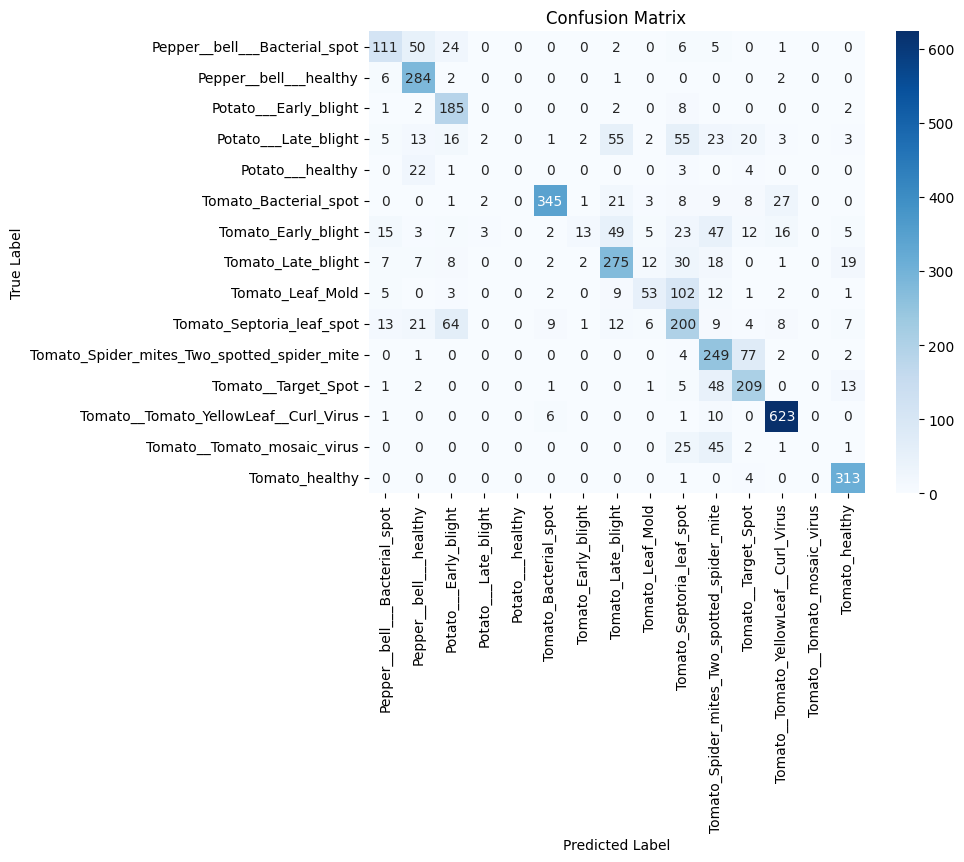

In [23]:
from sklearn.metrics import  precision_score, recall_score, f1_score
def evaluate_model(model, val_gen):
    """Evaluates model on validation data and prints accuracy, precision, recall, F1."""

    val_gen.reset()
    Y_pred = model.predict(val_gen, verbose=0)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = val_gen.classes

    acc = np.mean(y_pred == y_true)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Validation Accuracy: {acc:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall    (macro): {recall:.4f}")
    print(f"F1 Score  (macro): {f1:.4f}")

    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=list(val_gen.class_indices.keys())))

    return y_true, y_pred

y_true, y_pred = evaluate_model(model, val_generator)

cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8,6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Validation Accuracy: 69.43% – decent but there's clear room for improvement.

Weighted F1-score: 65.4% – aligns with the accuracy, indicating somewhat balanced precision and recall across the dataset.

Macro F1-score: 52.34% – lower than weighted, showing performance imbalance among classes.

These classes have very low recall or f1-scores, meaning your model struggles to identify them correctly:

Potato___Late_blight – Recall: 0.01, likely confused with other tomato or potato diseases.

Potato___healthy – Recall: 0.00, not detected at all.

Tomato__Tomato_mosaic_virus – Recall: 0.00, also never correctly predicted.



Model Size and Inference Speed

We can measure the model’s size and inference time. Saving the model to disk allows us to check its file size, which is a proxy for the number of parameters. We also time how long it takes to predict on the validation set to estimate per-image inference speed.

In [17]:

model_path = 'plant_disease_cnn_model.h5'
model.save(model_path)
model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
print(f"Model size: {model_size_mb:.2f} MB")


import time
start_time = time.time()
_ = model.predict(val_generator, verbose=0)
end_time = time.time()
total_time = end_time - start_time
avg_time_per_image = total_time / val_generator.samples
print(f"Average inference time per image: {avg_time_per_image:.4f} seconds")


Model size: 127.98 MB
Average inference time per image: 0.0357 seconds


Training and Validation Curves

Visualizing the training history helps diagnose underfitting or overfitting. Below we plot the training vs. validation accuracy and loss over epochs:

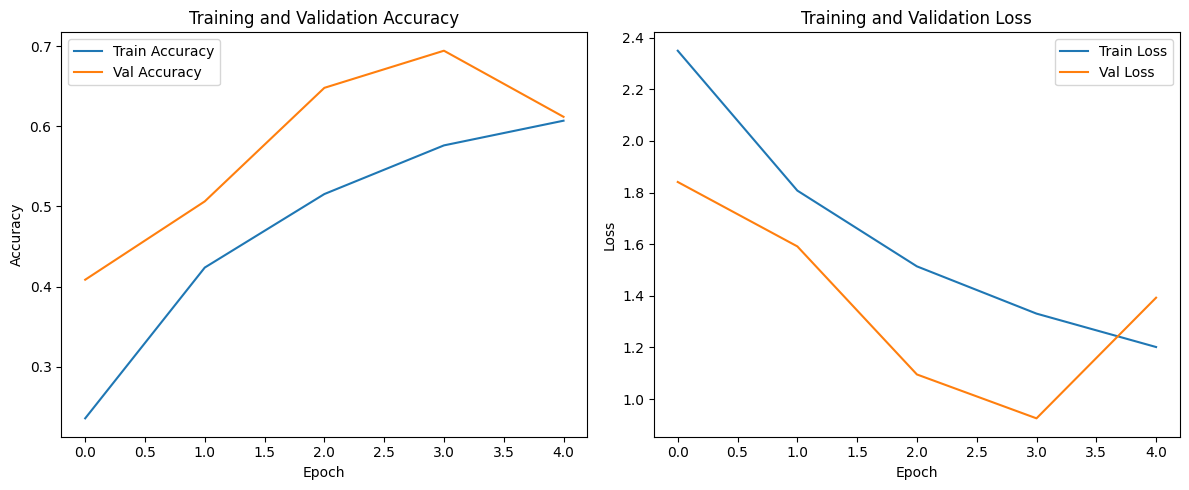

In [18]:
# Plot training & validation accuracy values
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


Sample Predictions

Finally, we visualize some sample predictions on validation images. This qualitative check shows the input image, its true label, and the model’s predicted label:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
Random Sample Accuracy: 0.8333


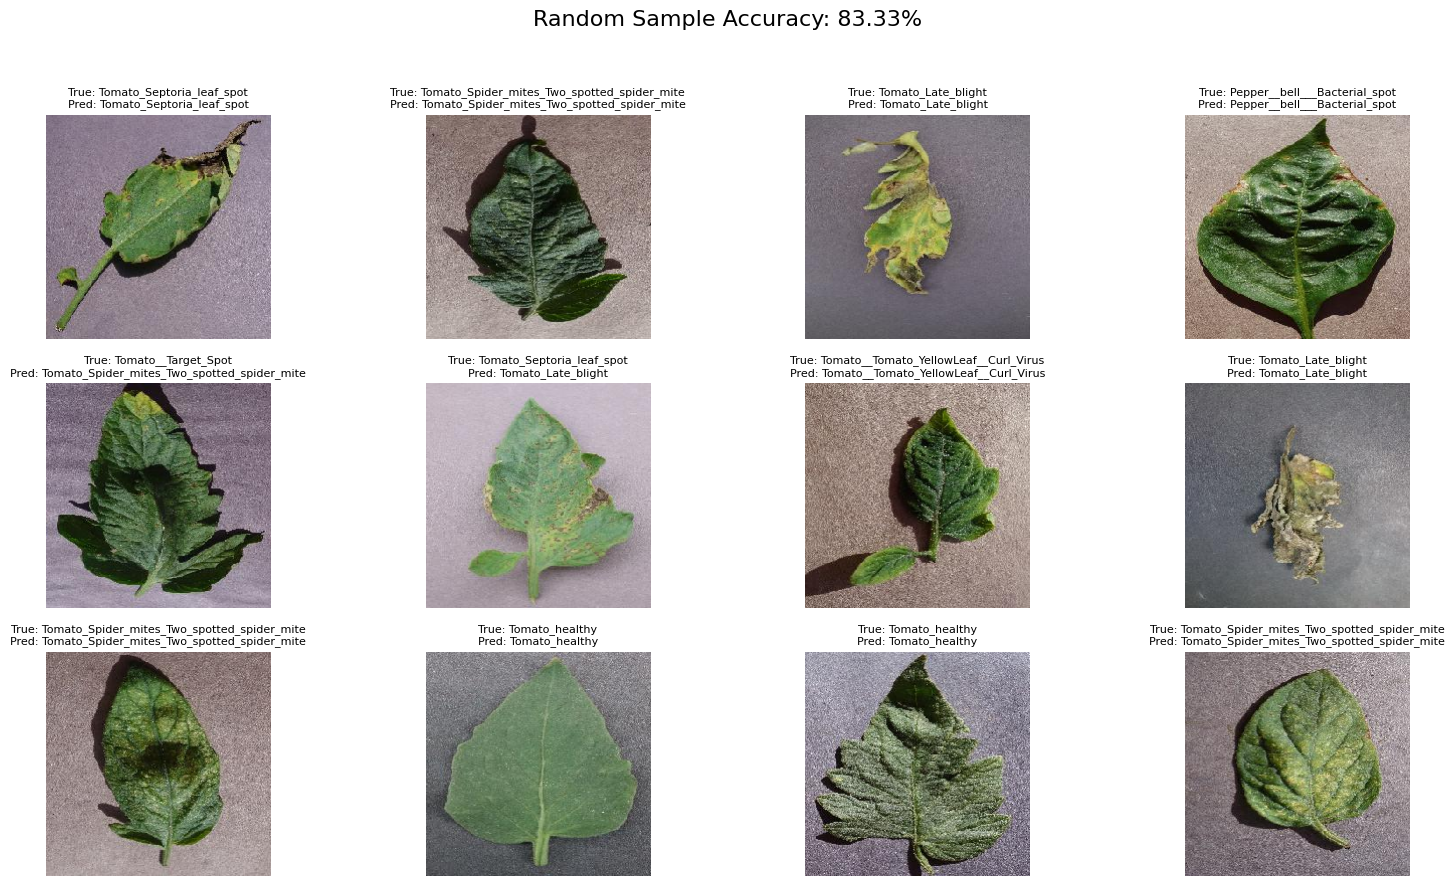

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
from tensorflow.keras.preprocessing import image

# Total number of validation samples
num_samples = len(val_generator.filenames)
class_names = list(val_generator.class_indices.keys())

# Randomly pick 12 indices
random_indices = random.sample(range(num_samples), 12)

# Get corresponding file paths
random_filepaths = [val_generator.filepaths[i] for i in random_indices]

# Load and preprocess the images manually
images = []
true_labels = []

for i in random_indices:
    img_path = val_generator.filepaths[i]
    img = image.load_img(img_path, target_size=val_generator.target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    images.append(img_array)
    true_labels.append(val_generator.classes[i])

images = np.array(images)
true_labels = np.array(true_labels)

# Make predictions
preds = model.predict(images)
predicted_labels = np.argmax(preds, axis=1)

# Compute accuracy for the selected samples
batch_accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Random Sample Accuracy: {batch_accuracy:.4f}")

# Plot
plt.figure(figsize=(16, 9))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}", fontsize=8)
plt.suptitle(f"Random Sample Accuracy: {batch_accuracy:.2%}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
